In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eye-diseases-classification/dataset/glaucoma/1255_right.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/1482_left.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_398_8823411.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_309_4110303.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_13_697490.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_205_310538.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/Glaucoma_040.png
/kaggle/input/eye-diseases-classification/dataset/glaucoma/1256_right.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_221_3079640.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_392_9636183.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_12_5295071.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_399_7128170.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_113_8738972.jpg
/kaggle/input/eye-disea

In [2]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np 
import PIL 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path
import random
import cv2
import warnings
warnings.filterwarnings("ignore")

2024-03-19 14:33:49.858194: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 14:33:49.858349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 14:33:50.076226: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Classes we have in our data set.
total_classes = os.listdir("/kaggle/input/eye-diseases-classification/dataset")
total_classes

['glaucoma', 'normal', 'diabetic_retinopathy', 'cataract']

In [5]:
# Total number of images per class.
images_path = Path("/kaggle/input/eye-diseases-classification/dataset")

for c in total_classes:
  print(f'* {c}', '=',len(os.listdir(os.path.join(images_path, c))), 'images')

* glaucoma = 1007 images
* normal = 1074 images
* diabetic_retinopathy = 1098 images
* cataract = 1038 images


In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4217 files belonging to 4 classes.
Using 843 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


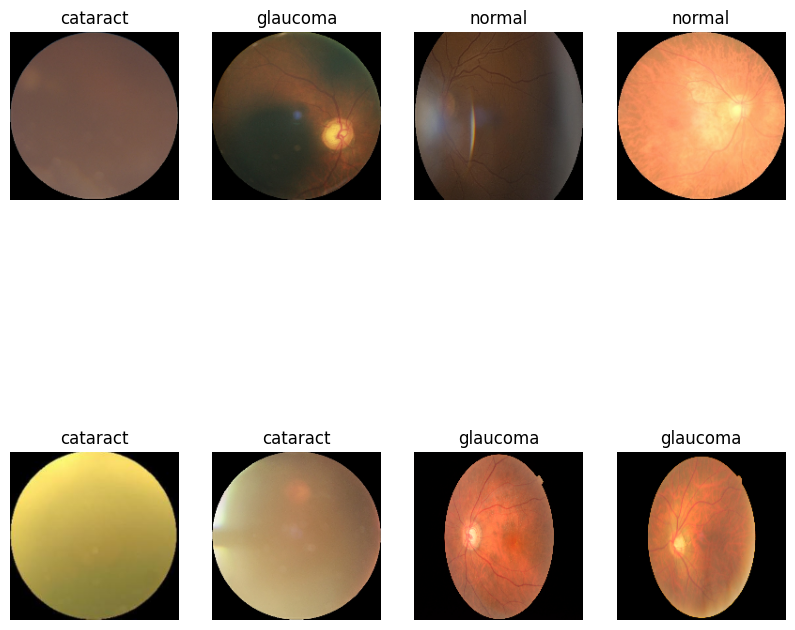

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardizing the dataset**

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in '[0,1]'

print(np.min(first_image), np.max(first_image))

0.0 1.0


**Creating the model**

In [16]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,156 (15.22 MB)

 Trainable params: 3,989,156 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
epochs = 10 

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 63s 572ms/step - accuracy: 0.4723 - loss: 1.2316 - val_accuracy: 0.6821 - val_loss: 0.7157
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 78s 537ms/step - accuracy: 0.7252 - loss: 0.6580 - val_accuracy: 0.7639 - val_loss: 0.5706
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 534ms/step - accuracy: 0.7438 - loss: 0.5916 - val_accuracy: 0.8185 - val_loss: 0.4942
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 57s 542ms/step - accuracy: 0.8032 - loss: 0.4914 - val_accuracy: 0.8102 - val_loss: 0.4903
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 81s 528ms/step - accuracy: 0.7976 - loss: 0.4797 - val_accuracy: 0.8233 - val_loss: 0.4377
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 55s 519ms/step - accuracy: 0.8419 - loss: 0.3923 - val_accuracy: 0.8339 - val_loss: 0.4438
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 527ms/step - accuracy: 0.8434 - loss: 0.3914 - val_accuracy: 0.8363 - val_loss: 0.4343
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 534ms/step - accuracy: 0.8486 - loss: 0

**Visualization of results**

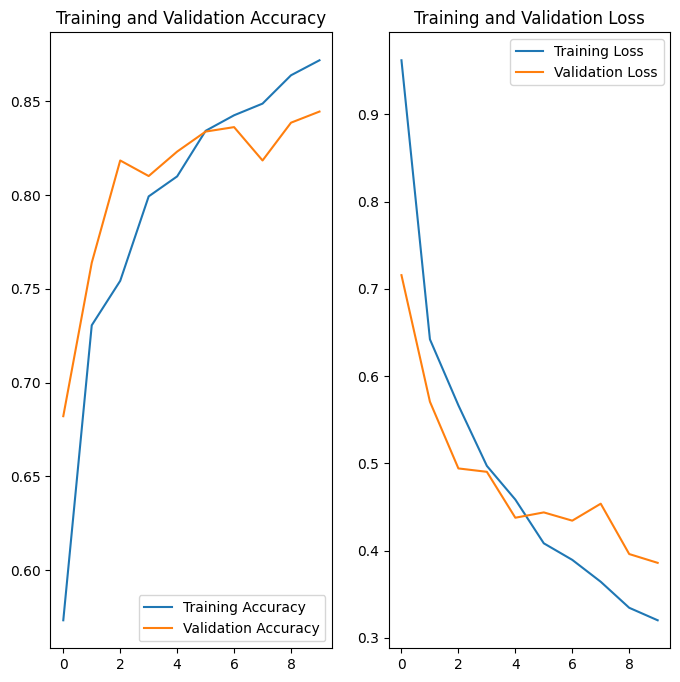

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Augumentation**

In [21]:
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                  3)),
    
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

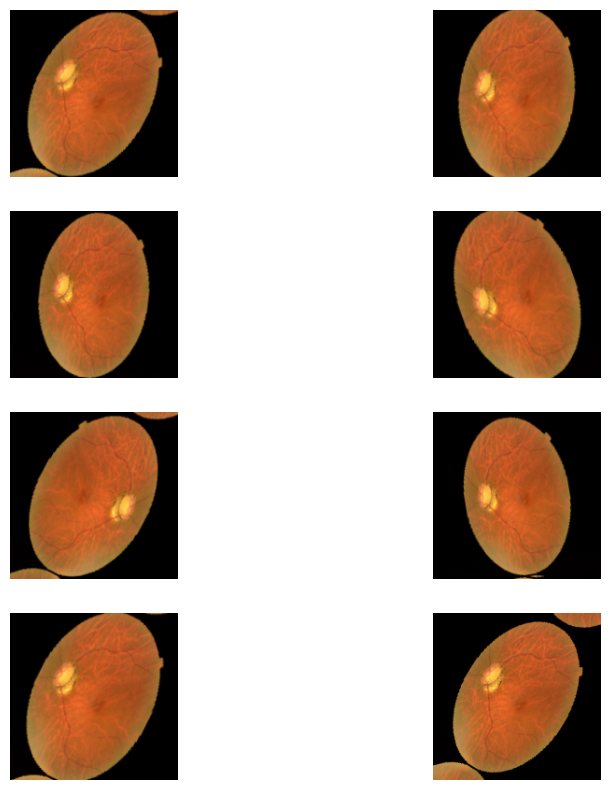

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(8):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4,2, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Adding a dropout layer**

In [23]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [24]:
model.compile(optimizer="adam",
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])

In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,156 (15.22 MB)

 Trainable params: 3,989,156 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
epochs = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 55s 517ms/step - accuracy: 0.9982 - loss: 0.0060 - val_accuracy: 0.8541 - val_loss: 0.7837
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 518ms/step - accuracy: 0.9916 - loss: 0.0207 - val_accuracy: 0.8612 - val_loss: 0.8152
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 517ms/step - accuracy: 0.9977 - loss: 0.0091 - val_accuracy: 0.8683 - val_loss: 0.7670
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 517ms/step - accuracy: 0.9987 - loss: 0.0068 - val_accuracy: 0.8636 - val_loss: 0.7497
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 517ms/step - accuracy: 0.9922 - loss: 0.0188 - val_accuracy: 0.8565 - val_loss: 0.7469
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 54s 514ms/step - accuracy: 0.9927 - loss: 0.0242 - val_accuracy: 0.8636 - val_loss: 0.7005
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 511ms/step - accuracy: 0.9940 - loss: 0.0190 - val_accuracy: 0.8624 - val_loss: 0.6273
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 55s 516ms/step - accuracy: 0.9962 - loss: 0